# Mount Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, GATConv, global_max_pool as gmp, global_add_pool as gap,global_mean_pool as gep,global_sort_pool
from torch_geometric.utils import dropout_adj


# GCN based model
class GNNNet(torch.nn.Module):
    def __init__(self, n_output=1, num_features_pro=54, num_features_mol=78, output_dim=128, dropout=0.2):
        super(GNNNet, self).__init__()

        print('GNNNet Loaded')
        self.n_output = n_output
        self.mol_conv1 = GCNConv(num_features_mol, num_features_mol)
        self.mol_conv2 = GCNConv(num_features_mol, num_features_mol * 2)
        self.mol_conv3 = GCNConv(num_features_mol * 2, num_features_mol * 4)
       
        self.mol_fc_g1 = torch.nn.Linear(num_features_mol * 4, 1024)
        self.mol_fc_g2 = torch.nn.Linear(1024, output_dim)

        self.pro_conv1 = GCNConv(num_features_pro, num_features_pro)
        self.pro_conv2 = GCNConv(num_features_pro, num_features_pro * 2)
        self.pro_conv3 = GCNConv(num_features_pro * 2, num_features_pro * 4)
       
        self.pro_fc_g1 = torch.nn.Linear(num_features_pro * 4, 1024)
        self.pro_fc_g2 = torch.nn.Linear(1024, output_dim)

        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.fc1 = nn.Linear(2 * output_dim, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.out = nn.Linear(512, self.n_output)

    def forward(self, data_mol, data_pro):
        
        # get molecule graph input
        mol_x, mol_edge_index, mol_batch = data_mol.x, data_mol.edge_index, data_mol.batch
        
        # get protein input
        target_x, target_edge_index, target_batch = data_pro.x, data_pro.edge_index, data_pro.batch

        # mol_edge_index, _ = dropout_adj(mol_edge_index, training=self.training)
        x = self.mol_conv1(mol_x, mol_edge_index)
        x = self.relu(x)

        # mol_edge_index, _ = dropout_adj(mol_edge_index, training=self.training)
        x = self.mol_conv2(x, mol_edge_index)
        x = self.relu(x)

        # mol_edge_index, _ = dropout_adj(mol_edge_index, training=self.training)
        x = self.mol_conv3(x, mol_edge_index)
        x = self.relu(x)

        x = gep(x, mol_batch)  # global pooling

        # flatten
        x = self.relu(self.mol_fc_g1(x))
        x = self.dropout(x)
        x = self.mol_fc_g2(x)
        x = self.dropout(x)
        
        
        target_edge_index_, _ = dropout_adj(target_edge_index, training=self.training, p=0.5)
        xt = self.pro_conv1(target_x, target_edge_index_)
        xt = self.relu(xt)

        target_edge_index_, _ = dropout_adj(target_edge_index, training=self.training, p=0.5)
        xt = self.pro_conv2(xt, target_edge_index_)
        xt = self.relu(xt)

        target_edge_index_, _ = dropout_adj(target_edge_index, training=self.training, p=0.5)
        xt = self.pro_conv3(xt, target_edge_index_)
        xt = self.relu(xt)

        xt = gep(xt, target_batch)  # global pooling

        # flatten
        xt = self.relu(self.pro_fc_g1(xt))
        xt = self.dropout(xt)
        xt = self.pro_fc_g2(xt)
        xt = self.dropout(xt)

        xc = torch.cat((x, xt), 1)

        # add some dense layers
        xc = self.fc1(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        xc = self.fc2(xc)
        xc = self.relu(xc)
        xc = self.dropout(xc)
        out = self.out(xc)
        return out


## Downloading Preprocessed Data for Protein Contact Maps

In [ ]:
!gdown https://drive.google.com/uc?id=1rqAopf_IaH3jzFkwXObQ4i-6bUUwizCv
!unzip data.zip
!cp -r /content/data/davis/aln /content/DGraphDTA/data/davis
!cp -r /content/data/davis/pconsc4 /content/DGraphDTA/data/davis

Downloading...
From: https://drive.google.com/uc?id=1rqAopf_IaH3jzFkwXObQ4i-6bUUwizCv
To: /content/data.zip
2.87GB [00:40, 71.0MB/s]
Archive:  data.zip
   creating: data/
   creating: data/davis/
   creating: data/davis/aln/
  inflating: data/davis/aln/AAK1.aln  
  inflating: data/davis/aln/ABL1(E255K).aln  
  inflating: data/davis/aln/ABL1(F317I).aln  
  inflating: data/davis/aln/ABL1(F317I)p.aln  
  inflating: data/davis/aln/ABL1(F317L).aln  
  inflating: data/davis/aln/ABL1(F317L)p.aln  
  inflating: data/davis/aln/ABL1(H396P).aln  
  inflating: data/davis/aln/ABL1(H396P)p.aln  
  inflating: data/davis/aln/ABL1(M351T).aln  
  inflating: data/davis/aln/ABL1(Q252H).aln  
  inflating: data/davis/aln/ABL1(Q252H)p.aln  
  inflating: data/davis/aln/ABL1(T315I).aln  
  inflating: data/davis/aln/ABL1(T315I)p.aln  
  inflating: data/davis/aln/ABL1(Y253F).aln  
  inflating: data/davis/aln/ABL1.aln  
  inflating: data/davis/aln/ABL1p.aln  
  inflating: data/davis/aln/ABL2.aln  
  inflating: da

## PIP Dependencies

In [ ]:
# !pip3 install numpy Cython pythran && pip3 install pconsc4
!pip install torch-geometric torch-scatter==latest+cu101 torch-sparse==latest+cu101 --no-cache-dir -f https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html


Looking in links: https://s3.eu-central-1.amazonaws.com/pytorch-geometric.com/whl/torch-1.5.0.html
     |████████████████████████████████| 153kB 3.4MB/s 
     |████████████████████████████████| 12.3MB 1.4MB/s 
     |████████████████████████████████| 21.6MB 1.3MB/s 
     |████████████████████████████████| 235kB 8.7MB/s 
     |████████████████████████████████| 2.1MB 12.3MB/s 
     |████████████████████████████████| 51kB 36.1MB/s 
  Created wheel for torch-geometric: filename=torch_geometric-1.5.0-cp36-none-any.whl size=267918 sha256=84d13fdda9e776c529f2354e1ecb5051f24abaaf6152984a0428c40f5a042e49
  Stored in directory: /tmp/pip-ephem-wheel-cache-94pt05hy/wheels/ec/51/31/5786f2ac419ee312f22d4d2877da05f20e7f2d430e22917daf
Successfully built torch-geometric


## RDKIT

In [ ]:
!wget -c https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
!chmod +x Miniconda3-latest-Linux-x86_64.sh
!time bash ./Miniconda3-latest-Linux-x86_64.sh -b -f -p /usr/local
!time conda install -q -y -c conda-forge rdkit

# !time conda install -c conda-forge -c bioconda hhsuite 
## !time conda install -q -y -c conda-forge bioconda hhsuite 
## !conda list -p /usr/local/lib/python3.7


import sys
sys.path.append('/usr/local/lib/python3.7/site-packages/')

--2020-07-05 18:35:41--  https://repo.continuum.io/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.continuum.io (repo.continuum.io)... 104.18.200.79, 104.18.201.79, 2606:4700::6812:c84f, ...
Connecting to repo.continuum.io (repo.continuum.io)|104.18.200.79|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh [following]
--2020-07-05 18:35:41--  https://repo.anaconda.com/miniconda/Miniconda3-latest-Linux-x86_64.sh
Resolving repo.anaconda.com (repo.anaconda.com)... 104.16.131.3, 104.16.130.3, 2606:4700::6810:8203, ...
Connecting to repo.anaconda.com (repo.anaconda.com)|104.16.131.3|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 88867207 (85M) [application/x-sh]
Saving to: ‘Miniconda3-latest-Linux-x86_64.sh’

Miniconda3-latest-L 100%[===================>]  84.75M   195MB/s    in 0.4s    

2020-07-05 18:35:42 (195 MB/s) - ‘Miniconda3-latest-Linux

## Cloning Repo

In [ ]:
!git clone https://github.com/595693085/DGraphDTA.git

Cloning into 'DGraphDTA'...
remote: Enumerating objects: 372, done.
remote: Counting objects: 100% (372/372), done.
remote: Compressing objects: 100% (341/341), done.
remote: Total 372 (delta 105), reused 245 (delta 19), pack-reused 0
Receiving objects: 100% (372/372), 50.23 MiB | 18.32 MiB/s, done.
Resolving deltas: 100% (105/105), done.


# evaluation metrics

In [ ]:
import numpy as np
import subprocess
from math import sqrt
from sklearn.metrics import average_precision_score
from scipy import stats


def get_aupr(Y, P, threshold=7.0):
    # print(Y.shape,P.shape)
    Y = np.where(Y >= 7.0, 1, 0)
    P = np.where(P >= 7.0, 1, 0)
    aupr = average_precision_score(Y, P)
    return aupr


def get_cindex(Y, P):
    summ = 0
    pair = 0

    for i in range(1, len(Y)):
        for j in range(0, i):
            if i is not j:
                if (Y[i] > Y[j]):
                    pair += 1
                    summ += 1 * (P[i] > P[j]) + 0.5 * (P[i] == P[j])

    if pair is not 0:
        return summ / pair
    else:
        return 0


def r_squared_error(y_obs, y_pred):
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
    y_obs_mean = [np.mean(y_obs) for y in y_obs]
    y_pred_mean = [np.mean(y_pred) for y in y_pred]

    mult = sum((y_pred - y_pred_mean) * (y_obs - y_obs_mean))
    mult = mult * mult

    y_obs_sq = sum((y_obs - y_obs_mean) * (y_obs - y_obs_mean))
    y_pred_sq = sum((y_pred - y_pred_mean) * (y_pred - y_pred_mean))

    return mult / float(y_obs_sq * y_pred_sq)


def get_k(y_obs, y_pred):
    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)

    return sum(y_obs * y_pred) / float(sum(y_pred * y_pred))


def squared_error_zero(y_obs, y_pred):
    k = get_k(y_obs, y_pred)

    y_obs = np.array(y_obs)
    y_pred = np.array(y_pred)
    y_obs_mean = [np.mean(y_obs) for y in y_obs]
    upp = sum((y_obs - (k * y_pred)) * (y_obs - (k * y_pred)))
    down = sum((y_obs - y_obs_mean) * (y_obs - y_obs_mean))

    return 1 - (upp / float(down))


def get_rm2(ys_orig, ys_line):
    r2 = r_squared_error(ys_orig, ys_line)
    r02 = squared_error_zero(ys_orig, ys_line)

    return r2 * (1 - np.sqrt(np.absolute((r2 * r2) - (r02 * r02))))


def get_rmse(y, f):
    rmse = sqrt(((y - f) ** 2).mean(axis=0))
    return rmse


def get_mse(y, f):
    mse = ((y - f) ** 2).mean(axis=0)
    return mse


def get_pearson(y, f):
    rp = np.corrcoef(y, f)[0, 1]
    return rp


def get_spearman(y, f):
    rs = stats.spearmanr(y, f)[0]
    return rs


def get_ci(y, f):
    ind = np.argsort(y)
    y = y[ind]
    f = f[ind]
    i = len(y) - 1
    j = i - 1
    z = 0.0
    S = 0.0
    while i > 0:
        while j >= 0:
            if y[i] > y[j]:
                z = z + 1
                u = f[i] - f[j]
                if u > 0:
                    S = S + 1
                elif u == 0:
                    S = S + 0.5
            j = j - 1
        i = i - 1
        j = i - 1
    ci = S / z
    return ci


# utilities

In [ ]:
import os
from torch_geometric.data import InMemoryDataset, DataLoader, Batch
from torch_geometric import data as DATA
import torch


# initialize the dataset
class DTADataset(InMemoryDataset):
    def __init__(self, root='/tmp', dataset='davis',
                 xd=None, y=None, transform=None,
                 pre_transform=None, smile_graph=None, target_key=None, target_graph=None):

        super(DTADataset, self).__init__(root, transform, pre_transform)
        self.dataset = dataset
        self.process(xd, target_key, y, smile_graph, target_graph)

    @property
    def raw_file_names(self):
        pass
        # return ['some_file_1', 'some_file_2', ...]

    @property
    def processed_file_names(self):
        return [self.dataset + '_data_mol.pt', self.dataset + '_data_pro.pt']

    def download(self):
        # Download to `self.raw_dir`.
        pass

    def _download(self):
        pass

    def _process(self):
        if not os.path.exists(self.processed_dir):
            os.makedirs(self.processed_dir)

    def process(self, xd, target_key, y, smile_graph, target_graph):
        assert (len(xd) == len(target_key) and len(xd) == len(y)), 'The three lists must be the same length!'
        data_list_mol = []
        data_list_pro = []
        data_len = len(xd)
        for i in range(data_len):
            smiles = xd[i]
            tar_key = target_key[i]
            labels = y[i]
            # convert SMILES to molecular representation using rdkit
            c_size, features, edge_index = smile_graph[smiles]
            target_size, target_features, target_edge_index = target_graph[tar_key]
            # print(np.array(features).shape, np.array(edge_index).shape)
            # print(target_features.shape, target_edge_index.shape)
            # make the graph ready for PyTorch Geometrics GCN algorithms:
            GCNData_mol = DATA.Data(x=torch.Tensor(features),
                                    edge_index=torch.LongTensor(edge_index).transpose(1, 0),
                                    y=torch.FloatTensor([labels]))
            GCNData_mol.__setitem__('c_size', torch.LongTensor([c_size]))

            GCNData_pro = DATA.Data(x=torch.Tensor(target_features),
                                    edge_index=torch.LongTensor(target_edge_index).transpose(1, 0),
                                    y=torch.FloatTensor([labels]))
            GCNData_pro.__setitem__('target_size', torch.LongTensor([target_size]))
            # print(GCNData.target.size(), GCNData.target_edge_index.size(), GCNData.target_x.size())
            data_list_mol.append(GCNData_mol)
            data_list_pro.append(GCNData_pro)

        if self.pre_filter is not None:
            data_list_mol = [data for data in data_list_mol if self.pre_filter(data)]
            data_list_pro = [data for data in data_list_pro if self.pre_filter(data)]
        if self.pre_transform is not None:
            data_list_mol = [self.pre_transform(data) for data in data_list_mol]
            data_list_pro = [self.pre_transform(data) for data in data_list_pro]
        self.data_mol = data_list_mol
        self.data_pro = data_list_pro

    def __len__(self):
        return len(self.data_mol)

    def __getitem__(self, idx):
        return self.data_mol[idx], self.data_pro[idx]


# training function at each epoch
def train(model, device, train_loader, optimizer, epoch):
    print('Training on {} samples...'.format(len(train_loader.dataset)))
    model.train()
    LOG_INTERVAL = 10
    TRAIN_BATCH_SIZE = 512
    loss_fn = torch.nn.MSELoss()
    for batch_idx, data in enumerate(train_loader):
        data_mol = data[0].to(device)
        data_pro = data[1].to(device)
        optimizer.zero_grad()
        output = model(data_mol, data_pro)
        loss = loss_fn(output, data_mol.y.view(-1, 1).float().to(device))
        loss.backward()
        optimizer.step()
        if batch_idx % LOG_INTERVAL == 0:
            print('Train epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(epoch,
                                                                           batch_idx * TRAIN_BATCH_SIZE,
                                                                           len(train_loader.dataset),
                                                                           100. * batch_idx / len(train_loader),
                                                                           loss.item()))

# predict
def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


#prepare the protein and drug pairs
def collate(data_list):
    batchA = Batch.from_data_list([data[0] for data in data_list])
    batchB = Batch.from_data_list([data[1] for data in data_list])
    return batchA, batchB


# gnn

# pre process

In [ ]:
import pandas as pd
import numpy as np
import os
import random
import json, pickle
from collections import OrderedDict
from rdkit import Chem
from rdkit.Chem import MolFromSmiles
import networkx as nx

# from utils import *


# nomarlize
def dic_normalize(dic):
    # print(dic)
    max_value = dic[max(dic, key=dic.get)]
    min_value = dic[min(dic, key=dic.get)]
    # print(max_value)
    interval = float(max_value) - float(min_value)
    for key in dic.keys():
        dic[key] = (dic[key] - min_value) / interval
    dic['X'] = (max_value + min_value) / 2.0
    return dic


pro_res_table = ['A', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N', 'P', 'Q', 'R', 'S', 'T', 'V', 'W', 'Y',
                 'X']

pro_res_aliphatic_table = ['A', 'I', 'L', 'M', 'V']
pro_res_aromatic_table = ['F', 'W', 'Y']
pro_res_polar_neutral_table = ['C', 'N', 'Q', 'S', 'T']
pro_res_acidic_charged_table = ['D', 'E']
pro_res_basic_charged_table = ['H', 'K', 'R']

res_weight_table = {'A': 71.08, 'C': 103.15, 'D': 115.09, 'E': 129.12, 'F': 147.18, 'G': 57.05, 'H': 137.14,
                    'I': 113.16, 'K': 128.18, 'L': 113.16, 'M': 131.20, 'N': 114.11, 'P': 97.12, 'Q': 128.13,
                    'R': 156.19, 'S': 87.08, 'T': 101.11, 'V': 99.13, 'W': 186.22, 'Y': 163.18}

res_pka_table = {'A': 2.34, 'C': 1.96, 'D': 1.88, 'E': 2.19, 'F': 1.83, 'G': 2.34, 'H': 1.82, 'I': 2.36,
                 'K': 2.18, 'L': 2.36, 'M': 2.28, 'N': 2.02, 'P': 1.99, 'Q': 2.17, 'R': 2.17, 'S': 2.21,
                 'T': 2.09, 'V': 2.32, 'W': 2.83, 'Y': 2.32}

res_pkb_table = {'A': 9.69, 'C': 10.28, 'D': 9.60, 'E': 9.67, 'F': 9.13, 'G': 9.60, 'H': 9.17,
                 'I': 9.60, 'K': 8.95, 'L': 9.60, 'M': 9.21, 'N': 8.80, 'P': 10.60, 'Q': 9.13,
                 'R': 9.04, 'S': 9.15, 'T': 9.10, 'V': 9.62, 'W': 9.39, 'Y': 9.62}

res_pkx_table = {'A': 0.00, 'C': 8.18, 'D': 3.65, 'E': 4.25, 'F': 0.00, 'G': 0, 'H': 6.00,
                 'I': 0.00, 'K': 10.53, 'L': 0.00, 'M': 0.00, 'N': 0.00, 'P': 0.00, 'Q': 0.00,
                 'R': 12.48, 'S': 0.00, 'T': 0.00, 'V': 0.00, 'W': 0.00, 'Y': 0.00}

res_pl_table = {'A': 6.00, 'C': 5.07, 'D': 2.77, 'E': 3.22, 'F': 5.48, 'G': 5.97, 'H': 7.59,
                'I': 6.02, 'K': 9.74, 'L': 5.98, 'M': 5.74, 'N': 5.41, 'P': 6.30, 'Q': 5.65,
                'R': 10.76, 'S': 5.68, 'T': 5.60, 'V': 5.96, 'W': 5.89, 'Y': 5.96}

res_hydrophobic_ph2_table = {'A': 47, 'C': 52, 'D': -18, 'E': 8, 'F': 92, 'G': 0, 'H': -42, 'I': 100,
                             'K': -37, 'L': 100, 'M': 74, 'N': -41, 'P': -46, 'Q': -18, 'R': -26, 'S': -7,
                             'T': 13, 'V': 79, 'W': 84, 'Y': 49}

res_hydrophobic_ph7_table = {'A': 41, 'C': 49, 'D': -55, 'E': -31, 'F': 100, 'G': 0, 'H': 8, 'I': 99,
                             'K': -23, 'L': 97, 'M': 74, 'N': -28, 'P': -46, 'Q': -10, 'R': -14, 'S': -5,
                             'T': 13, 'V': 76, 'W': 97, 'Y': 63}

res_weight_table = dic_normalize(res_weight_table)
res_pka_table = dic_normalize(res_pka_table)
res_pkb_table = dic_normalize(res_pkb_table)
res_pkx_table = dic_normalize(res_pkx_table)
res_pl_table = dic_normalize(res_pl_table)
res_hydrophobic_ph2_table = dic_normalize(res_hydrophobic_ph2_table)
res_hydrophobic_ph7_table = dic_normalize(res_hydrophobic_ph7_table)


# print(res_weight_table)


def residue_features(residue):
    res_property1 = [1 if residue in pro_res_aliphatic_table else 0, 1 if residue in pro_res_aromatic_table else 0,
                     1 if residue in pro_res_polar_neutral_table else 0,
                     1 if residue in pro_res_acidic_charged_table else 0,
                     1 if residue in pro_res_basic_charged_table else 0]
    res_property2 = [res_weight_table[residue], res_pka_table[residue], res_pkb_table[residue], res_pkx_table[residue],
                     res_pl_table[residue], res_hydrophobic_ph2_table[residue], res_hydrophobic_ph7_table[residue]]
    # print(np.array(res_property1 + res_property2).shape)
    return np.array(res_property1 + res_property2)


# mol atom feature for mol graph
def atom_features(atom):
    # 44 +11 +11 +11 +1
    return np.array(one_of_k_encoding_unk(atom.GetSymbol(),
                                          ['C', 'N', 'O', 'S', 'F', 'Si', 'P', 'Cl', 'Br', 'Mg', 'Na', 'Ca', 'Fe', 'As',
                                           'Al', 'I', 'B', 'V', 'K', 'Tl', 'Yb', 'Sb', 'Sn', 'Ag', 'Pd', 'Co', 'Se',
                                           'Ti', 'Zn', 'H', 'Li', 'Ge', 'Cu', 'Au', 'Ni', 'Cd', 'In', 'Mn', 'Zr', 'Cr',
                                           'Pt', 'Hg', 'Pb', 'X']) +
                    one_of_k_encoding(atom.GetDegree(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) +
                    one_of_k_encoding_unk(atom.GetTotalNumHs(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) +
                    one_of_k_encoding_unk(atom.GetImplicitValence(), [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10]) +
                    [atom.GetIsAromatic()])


# one ont encoding
def one_of_k_encoding(x, allowable_set):
    if x not in allowable_set:
        # print(x)
        raise Exception('input {0} not in allowable set{1}:'.format(x, allowable_set))
    return list(map(lambda s: x == s, allowable_set))


def one_of_k_encoding_unk(x, allowable_set):
    '''Maps inputs not in the allowable set to the last element.'''
    if x not in allowable_set:
        x = allowable_set[-1]
    return list(map(lambda s: x == s, allowable_set))


# mol smile to mol graph edge index
def smile_to_graph(smile):
    mol = Chem.MolFromSmiles(smile)

    c_size = mol.GetNumAtoms()

    features = []
    for atom in mol.GetAtoms():
        feature = atom_features(atom)
        features.append(feature / sum(feature))

    edges = []
    for bond in mol.GetBonds():
        edges.append([bond.GetBeginAtomIdx(), bond.GetEndAtomIdx()])
    g = nx.Graph(edges).to_directed()
    edge_index = []
    mol_adj = np.zeros((c_size, c_size))
    for e1, e2 in g.edges:
        mol_adj[e1, e2] = 1
        # edge_index.append([e1, e2])
    mol_adj += np.matrix(np.eye(mol_adj.shape[0]))
    index_row, index_col = np.where(mol_adj >= 0.5)
    for i, j in zip(index_row, index_col):
        edge_index.append([i, j])
    # print('smile_to_graph')
    # print(np.array(features).shape)
    return c_size, features, edge_index


# target feature for target graph
def PSSM_calculation(aln_file, pro_seq):
    pfm_mat = np.zeros((len(pro_res_table), len(pro_seq)))
    with open(aln_file, 'r') as f:
        line_count = len(f.readlines())
        for line in f.readlines():
            if len(line) != len(pro_seq):
                print('error', len(line), len(pro_seq))
                continue
            count = 0
            for res in line:
                if res not in pro_res_table:
                    count += 1
                    continue
                pfm_mat[pro_res_table.index(res), count] += 1
                count += 1
    # ppm_mat = pfm_mat / float(line_count)
    pseudocount = 0.8
    ppm_mat = (pfm_mat + pseudocount / 4) / (float(line_count) + pseudocount)
    pssm_mat = ppm_mat
    # k = float(len(pro_res_table))
    # pwm_mat = np.log2(ppm_mat / (1.0 / k))
    # pssm_mat = pwm_mat
    # print(pssm_mat)
    return pssm_mat


def seq_feature(pro_seq):
    pro_hot = np.zeros((len(pro_seq), len(pro_res_table)))
    pro_property = np.zeros((len(pro_seq), 12))
    for i in range(len(pro_seq)):
        # if 'X' in pro_seq:
        #     print(pro_seq)
        pro_hot[i,] = one_of_k_encoding(pro_seq[i], pro_res_table)
        pro_property[i,] = residue_features(pro_seq[i])
    return np.concatenate((pro_hot, pro_property), axis=1)


def target_feature(aln_file, pro_seq):
    pssm = PSSM_calculation(aln_file, pro_seq)
    other_feature = seq_feature(pro_seq)
    # print('target_feature')
    # print(pssm.shape)
    # print(other_feature.shape)

    # print(other_feature.shape)
    # return other_feature
    return np.concatenate((np.transpose(pssm, (1, 0)), other_feature), axis=1)


# target aln file save in data/dataset/aln
def target_to_feature(target_key, target_sequence, aln_dir):
    # aln_dir = 'data/' + dataset + '/aln'
    aln_file = os.path.join(aln_dir, target_key + '.aln')
    # if 'X' in target_sequence:
    #     print(target_key)
    feature = target_feature(aln_file, target_sequence)
    return feature


# pconsc4 predicted contact map save in data/dataset/pconsc4
def target_to_graph(target_key, target_sequence, contact_dir, aln_dir):
    target_edge_index = []
    target_size = len(target_sequence)
    # contact_dir = 'data/' + dataset + '/pconsc4'
    contact_file = os.path.join(contact_dir, target_key + '.npy')
    contact_map = np.load(contact_file)
    contact_map += np.matrix(np.eye(contact_map.shape[0]))
    index_row, index_col = np.where(contact_map >= 0.5)
    for i, j in zip(index_row, index_col):
        target_edge_index.append([i, j])
    target_feature = target_to_feature(target_key, target_sequence, aln_dir)
    target_edge_index = np.array(target_edge_index)
    return target_size, target_feature, target_edge_index


# to judge whether the required files exist
def valid_target(key, dataset):
    contact_dir = 'data/' + dataset + '/pconsc4'
    aln_dir = 'data/' + dataset + '/aln'
    contact_file = os.path.join(contact_dir, key + '.npy')
    aln_file = os.path.join(aln_dir, key + '.aln')
    # print(contact_file, aln_file)
    if os.path.exists(contact_file) and os.path.exists(aln_file):
        return True
    else:
        return False


def data_to_csv(csv_file, datalist):
    with open(csv_file, 'w') as f:
        f.write('compound_iso_smiles,target_sequence,target_key,affinity\n')
        for data in datalist:
            f.write(','.join(map(str, data)) + '\n')


def create_dataset_for_test(dataset):
    # load dataset
    dataset_path = 'data/' + dataset + '/'
    test_fold = json.load(open(dataset_path + 'folds/test_fold_setting1.txt'))
    ligands = json.load(open(dataset_path + 'ligands_can.txt'), object_pairs_hook=OrderedDict)
    proteins = json.load(open(dataset_path + 'proteins.txt'), object_pairs_hook=OrderedDict)
    affinity = pickle.load(open(dataset_path + 'Y', 'rb'), encoding='latin1')
    # load contact and aln
    msa_path = 'data/' + dataset + '/aln'
    contac_path = 'data/' + dataset + '/pconsc4'
    msa_list = []
    contact_list = []
    for key in proteins:
        msa_list.append(os.path.join(msa_path, key + '.aln'))
        contact_list.append(os.path.join(contac_path, key + '.npy'))

    drugs = []
    prots = []
    prot_keys = []
    drug_smiles = []
    # smiles
    for d in ligands.keys():
        lg = Chem.MolToSmiles(Chem.MolFromSmiles(ligands[d]), isomericSmiles=True)
        drugs.append(lg)
        drug_smiles.append(ligands[d])
    # seqs
    for t in proteins.keys():
        prots.append(proteins[t])
        prot_keys.append(t)
    if dataset == 'davis':
        affinity = [-np.log10(y / 1e9) for y in affinity]
    affinity = np.asarray(affinity)

    valid_test_count = 0
    rows, cols = np.where(np.isnan(affinity) == False)
    rows, cols = rows[test_fold], cols[test_fold]
    temp_test_entries = []
    for pair_ind in range(len(rows)):
        # if the required files is not exist, then pass
        if not valid_target(prot_keys[cols[pair_ind]], dataset):
            continue
        ls = []
        ls += [drugs[rows[pair_ind]]]
        ls += [prots[cols[pair_ind]]]
        ls += [prot_keys[cols[pair_ind]]]
        ls += [affinity[rows[pair_ind], cols[pair_ind]]]
        temp_test_entries.append(ls)
        valid_test_count += 1
    csv_file = 'data/' + dataset + '_test.csv'
    data_to_csv(csv_file, temp_test_entries)
    print('dataset:', dataset)
    print('test entries:', len(test_fold), 'effective test entries', valid_test_count)

    compound_iso_smiles = drugs
    target_key = prot_keys

    # create smile graph
    smile_graph = {}
    for smile in compound_iso_smiles:
        g = smile_to_graph(smile)
        smile_graph[smile] = g
    # print(smile_graph['CN1CCN(C(=O)c2cc3cc(Cl)ccc3[nH]2)CC1']) #for test

    # create target graph
    # print('target_key', len(target_key), len(set(target_key)))
    target_graph = {}
    for key in target_key:
        if not valid_target(key, dataset):  # ensure the contact and aln files exists
            continue
        g = target_to_graph(key, proteins[key], contac_path, msa_path)
        target_graph[key] = g

    # count the number of  proteins with aln and contact files
    print('effective drugs,effective prot:', len(smile_graph), len(target_graph))
    if len(smile_graph) == 0 or len(target_graph) == 0:
        raise Exception('no protein or drug, run the script for datasets preparation.')

    # 'data/davis_test.csv' or data/kiba_test.csv'
    df_test = pd.read_csv('data/' + dataset + '_test.csv')
    test_drugs, test_prot_keys, test_Y = list(df_test['compound_iso_smiles']), list(df_test['target_key']), list(
        df_test['affinity'])
    test_drugs, test_prot_keys, test_Y = np.asarray(test_drugs), np.asarray(test_prot_keys), np.asarray(test_Y)
    test_dataset = DTADataset(root='data', dataset=dataset + '_test', xd=test_drugs, y=test_Y,
                              target_key=test_prot_keys, smile_graph=smile_graph, target_graph=target_graph)

    return test_dataset


def create_dataset_for_5folds(dataset, fold=0):
    # load dataset
    dataset_path = 'data/' + dataset + '/'
    train_fold_origin = json.load(open(dataset_path + 'folds/train_fold_setting1.txt'))
    train_fold_origin = [e for e in train_fold_origin]  # for 5 folds

    ligands = json.load(open(dataset_path + 'ligands_can.txt'), object_pairs_hook=OrderedDict)
    proteins = json.load(open(dataset_path + 'proteins.txt'), object_pairs_hook=OrderedDict)
    # load contact and aln
    msa_path = 'data/' + dataset + '/aln'
    contac_path = 'data/' + dataset + '/pconsc4'
    msa_list = []
    contact_list = []
    for key in proteins:
        msa_list.append(os.path.join(msa_path, key + '.aln'))
        contact_list.append(os.path.join(contac_path, key + '.npy'))

    # load train,valid and test entries
    train_folds = []
    valid_fold = train_fold_origin[fold]  # one fold
    for i in range(len(train_fold_origin)):  # other folds
        if i != fold:
            train_folds += train_fold_origin[i]

    affinity = pickle.load(open(dataset_path + 'Y', 'rb'), encoding='latin1')
    drugs = []
    prots = []
    prot_keys = []
    drug_smiles = []
    # smiles
    for d in ligands.keys():
        lg = Chem.MolToSmiles(Chem.MolFromSmiles(ligands[d]), isomericSmiles=True)
        drugs.append(lg)
        drug_smiles.append(ligands[d])
    # seqs
    for t in proteins.keys():
        prots.append(proteins[t])
        prot_keys.append(t)
    if dataset == 'davis':
        affinity = [-np.log10(y / 1e9) for y in affinity]
    affinity = np.asarray(affinity)

    opts = ['train', 'valid']
    valid_train_count = 0
    valid_valid_count = 0
    for opt in opts:
        if opt == 'train':
            rows, cols = np.where(np.isnan(affinity) == False)
            rows, cols = rows[train_folds], cols[train_folds]
            train_fold_entries = []
            for pair_ind in range(len(rows)):
                if not valid_target(prot_keys[cols[pair_ind]], dataset):  # ensure the contact and aln files exists
                    continue
                ls = []
                ls += [drugs[rows[pair_ind]]]
                ls += [prots[cols[pair_ind]]]
                ls += [prot_keys[cols[pair_ind]]]
                ls += [affinity[rows[pair_ind], cols[pair_ind]]]
                train_fold_entries.append(ls)
                valid_train_count += 1

            csv_file = 'data/' + dataset + '_' + 'fold_' + str(fold) + '_' + opt + '.csv'
            data_to_csv(csv_file, train_fold_entries)
        elif opt == 'valid':
            rows, cols = np.where(np.isnan(affinity) == False)
            rows, cols = rows[valid_fold], cols[valid_fold]
            valid_fold_entries = []
            for pair_ind in range(len(rows)):
                if not valid_target(prot_keys[cols[pair_ind]], dataset):
                    continue
                ls = []
                ls += [drugs[rows[pair_ind]]]
                ls += [prots[cols[pair_ind]]]
                ls += [prot_keys[cols[pair_ind]]]
                ls += [affinity[rows[pair_ind], cols[pair_ind]]]
                valid_fold_entries.append(ls)
                valid_valid_count += 1

            csv_file = 'data/' + dataset + '_' + 'fold_' + str(fold) + '_' + opt + '.csv'
            data_to_csv(csv_file, valid_fold_entries)
    print('dataset:', dataset)
    # print('len(set(drugs)),len(set(prots)):', len(set(drugs)), len(set(prots)))

    # entries with protein contact and aln files are marked as effiective
    print('fold:', fold)
    print('train entries:', len(train_folds), 'effective train entries', valid_train_count)
    print('valid entries:', len(valid_fold), 'effective valid entries', valid_valid_count)

    compound_iso_smiles = drugs
    target_key = prot_keys

    # create smile graph
    smile_graph = {}
    for smile in compound_iso_smiles:
        g = smile_to_graph(smile)
        smile_graph[smile] = g
    # print(smile_graph['CN1CCN(C(=O)c2cc3cc(Cl)ccc3[nH]2)CC1']) #for test

    # create target graph
    # print('target_key', len(target_key), len(set(target_key)))
    target_graph = {}
    for key in target_key:
        if not valid_target(key, dataset):  # ensure the contact and aln files exists
            continue
        g = target_to_graph(key, proteins[key], contac_path, msa_path)
        target_graph[key] = g

    # count the number of  proteins with aln and contact files
    print('effective drugs,effective prot:', len(smile_graph), len(target_graph))
    if len(smile_graph) == 0 or len(target_graph) == 0:
        raise Exception('no protein or drug, run the script for datasets preparation.')

    # 'data/davis_fold_0_train.csv' or data/kiba_fold_0__train.csv'
    train_csv = 'data/' + dataset + '_' + 'fold_' + str(fold) + '_' + 'train' + '.csv'
    df_train_fold = pd.read_csv(train_csv)
    train_drugs, train_prot_keys, train_Y = list(df_train_fold['compound_iso_smiles']), list(
        df_train_fold['target_key']), list(df_train_fold['affinity'])
    train_drugs, train_prot_keys, train_Y = np.asarray(train_drugs), np.asarray(train_prot_keys), np.asarray(train_Y)
    train_dataset = DTADataset(root='data', dataset=dataset + '_' + 'train', xd=train_drugs, target_key=train_prot_keys,
                               y=train_Y, smile_graph=smile_graph, target_graph=target_graph)


    df_valid_fold = pd.read_csv('data/' + dataset + '_' + 'fold_' + str(fold) + '_' + 'valid' + '.csv')
    valid_drugs, valid_prots_keys, valid_Y = list(df_valid_fold['compound_iso_smiles']), list(
        df_valid_fold['target_key']), list(df_valid_fold['affinity'])
    valid_drugs, valid_prots_keys, valid_Y = np.asarray(valid_drugs), np.asarray(valid_prots_keys), np.asarray(
        valid_Y)
    valid_dataset = DTADataset(root='data', dataset=dataset + '_' + 'train', xd=valid_drugs,
                               target_key=valid_prots_keys, y=valid_Y, smile_graph=smile_graph,
                               target_graph=target_graph)
    return train_dataset, valid_dataset


# training_5folds

In [ ]:
%cd /content/DGraphDTA

/content/DGraphDTA


In [ ]:
import sys, os
import torch
import torch.nn as nn
from torch_geometric.data import DataLoader

# from gnn import GNNNet
# from utils import *
# from emetrics import *
# from data_process import create_dataset_for_5folds


datasets = 'davis'

cuda_name = 'cuda:0'
print('cuda_name:', cuda_name)
fold = 0 # [0, 1, 2, 3, 4][int(sys.argv[3])]
cross_validation_flag = True

TRAIN_BATCH_SIZE = 512
TEST_BATCH_SIZE = 512
LR = 0.001
NUM_EPOCHS = 2000

print('Learning rate: ', LR)
print('Epochs: ', NUM_EPOCHS)

models_dir = '/content/drive/My Drive/DGraphDTA/models' # set your own path
results_dir = '/content/drive/My Drive/DGraphDTA/results' # set your own path

if not os.path.exists(models_dir):
    os.makedirs(models_dir)

if not os.path.exists(results_dir):
    os.makedirs(results_dir)


result_str = ''
USE_CUDA = torch.cuda.is_available()
device = torch.device(cuda_name if USE_CUDA else 'cpu')
model = GNNNet()
model.to(device)
model_st = GNNNet.__name__
model_file_name = os.path.join(models_dir,'model_' + model_st + '_' + dataset + '_' + str(fold) + '.model')

########## UNCOMMENT IN CASE YOU NEED TO RESUME TRAINING ##############
# state = torch.load(model_file_name)
# model.load_state_dict(state['state_dict'])
#######################################################################


loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)

########## UNCOMMENT IN CASE YOU NEED TO RESUME TRAINING ##############
# optimizer.load_state_dict(state['optimizer'])
#######################################################################

train_data, valid_data = create_dataset_for_5folds(dataset, fold)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=TRAIN_BATCH_SIZE, shuffle=True,
                                            collate_fn=collate)
valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                            collate_fn=collate)

best_mse = 1000
best_test_mse = 1000
best_epoch = -1


loss_mse = []
for epoch in range(NUM_EPOCHS):
    train(model, device, train_loader, optimizer, epoch + 1)
    print('predicting for valid data')
    G, P = predicting(model, device, valid_loader)
    val = get_mse(G, P)
    loss_mse.append(val)
    print('valid result:', val, best_mse)
    if val < best_mse:
        best_mse = val
        best_epoch = epoch + 1

        state = {
                    'epoch': epoch,
                    'state_dict': model.state_dict(),
                    'optimizer': optimizer.state_dict(),
                }
        torch.save(state, model_file_name)
        
        np.save(results_dir+"/loss.npy",np.array(loss_mse))

        # torch.save(model.state_dict(), model_file_name)
        print('rmse improved at epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)
    else:
        print('No improvement since epoch ', best_epoch, '; best_test_mse', best_mse, model_st, dataset, fold)


cuda_name: cuda:0
Learning rate:  0.001
Epochs:  2000
GNNNet Loaded
dataset: davis
fold: 0
train entries: 20036 effective train entries 20036
valid entries: 5010 effective valid entries 5010
effective drugs,effective prot: 68 442
Training on 20036 samples...
Train epoch: 1 [0/20036 (0%)]	Loss: 30.330486
Train epoch: 1 [5120/20036 (25%)]	Loss: 1.954011
Train epoch: 1 [10240/20036 (50%)]	Loss: 2.952061
Train epoch: 1 [15360/20036 (75%)]	Loss: 1.565945
predicting for valid data
Make prediction for 5010 samples...
valid result: 1.0046223 1000
rmse improved at epoch  1 ; best_test_mse 1.0046223 GNNNet davis 0
Training on 20036 samples...
Train epoch: 2 [0/20036 (0%)]	Loss: 1.045606
Train epoch: 2 [5120/20036 (25%)]	Loss: 0.992288
Train epoch: 2 [10240/20036 (50%)]	Loss: 0.817557
Train epoch: 2 [15360/20036 (75%)]	Loss: 0.836662
predicting for valid data
Make prediction for 5010 samples...
valid result: 0.8408129 1.0046223
rmse improved at epoch  2 ; best_test_mse 0.8408129 GNNNet davis 0
Tr

# test 

dataset: davis
cuda_name: cuda:0
GNNNet Loaded
dataset: davis
test entries: 5010 effective test entries 5010
effective drugs,effective prot: 68 442
Make prediction for 5010 samples...
metrics for  davis
cindex: 0.8454382174704543
cindex2 0.8459144155396036
rm2: 0.5779081222614397
mse: 0.33864
pearson 0.7677362570334195
davis
rmse:0.5819278343544314  mse:0.33864  pearson:0.7677362570334195 spearman:0.6326158917853564 ci:0.8454382174704543 rm2:0.5779081222614397


No handles with labels found to put in legend.


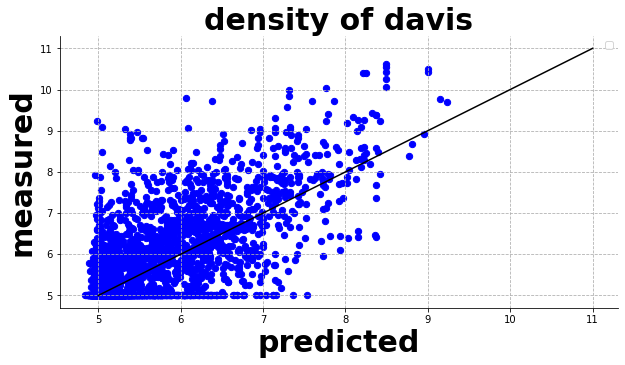

In [ ]:
import os
import sys
import torch
import numpy as np
from random import shuffle
import matplotlib.pyplot as plt
from torch_geometric.data import Batch

# from emetrics import get_aupr, get_cindex, get_rm2, get_ci, get_mse, get_rmse, get_pearson, get_spearman
# from utils import *
from scipy import stats
# from gnn import GNNNet
# from data_process import create_dataset_for_test


def predicting(model, device, loader):
    model.eval()
    total_preds = torch.Tensor()
    total_labels = torch.Tensor()
    print('Make prediction for {} samples...'.format(len(loader.dataset)))
    with torch.no_grad():
        for data in loader:
            data_mol = data[0].to(device)
            data_pro = data[1].to(device)
            # data = data.to(device)
            output = model(data_mol, data_pro)
            total_preds = torch.cat((total_preds, output.cpu()), 0)
            total_labels = torch.cat((total_labels, data_mol.y.view(-1, 1).cpu()), 0)
    return total_labels.numpy().flatten(), total_preds.numpy().flatten()


def load_model(model_path):
    model = torch.load(model_path)
    return model


def calculate_metrics(Y, P, dataset='davis',results_dir):
    # aupr = get_aupr(Y, P)
    cindex = get_cindex(Y, P)  # DeepDTA
    cindex2 = get_ci(Y, P)  # GraphDTA
    rm2 = get_rm2(Y, P)  # DeepDTA
    mse = get_mse(Y, P)
    pearson = get_pearson(Y, P)
    spearman = get_spearman(Y, P)
    rmse = get_rmse(Y, P)

    print('metrics for ', dataset)
    # print('aupr:', aupr)
    print('cindex:', cindex)
    print('cindex2', cindex2)
    print('rm2:', rm2)
    print('mse:', mse)
    print('pearson', pearson)

    result_file_name = results_dir +'/result_' + model_st + '_' + dataset + '.txt'
    result_str = ''
    result_str += dataset + '\r\n'
    result_str += 'rmse:' + str(rmse) + ' ' + ' mse:' + str(mse) + ' ' + ' pearson:' + str(
        pearson) + ' ' + 'spearman:' + str(spearman) + ' ' + 'ci:' + str(cindex) + ' ' + 'rm2:' + str(rm2)
    print(result_str)
    open(result_file_name, 'w').writelines(result_str)


def plot_density(Y, P, fold=0, dataset='davis',results_dir):
    plt.figure(figsize=(10, 5))
    plt.grid(linestyle='--')
    ax = plt.gca()
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.scatter(P, Y, color='blue', s=40)
    plt.title('density of ' + dataset, fontsize=30, fontweight='bold')
    plt.xlabel('predicted', fontsize=30, fontweight='bold')
    plt.ylabel('measured', fontsize=30, fontweight='bold')
    # plt.xlim(0, 21)
    # plt.ylim(0, 21)
    if dataset == 'davis':
        plt.plot([5, 11], [5, 11], color='black')
    else:
        plt.plot([6, 16], [6, 16], color='black')
    # plt.legend()
    plt.legend(loc=0, numpoints=1)
    leg = plt.gca().get_legend()
    ltext = leg.get_texts()
    plt.setp(ltext, fontsize=12, fontweight='bold')
    plt.savefig(os.path.join(results_dir, dataset + '_' + str(fold) + '.png'), dpi=500, bbox_inches='tight')


if __name__ == '__main__':
    dataset = 'davis'  # dataset selection
    model_st = GNNNet.__name__
    print('dataset:', dataset)
    fold = 0
    cuda_name = 'cuda:0'  # gpu selection
    print('cuda_name:', cuda_name)

    TEST_BATCH_SIZE = 512
    models_dir = '/content/drive/My Drive/DGraphDTA/models'
    results_dir = '/content/drive/My Drive/DGraphDTA/results'

    device = torch.device(cuda_name if torch.cuda.is_available() else 'cpu')
    model_file_name = models_dir+'/model_' + model_st + '_' + dataset + '_'+str(fold).model'
    result_file_name = results_dir+'/result_' + model_st + '_' + dataset + '.txt'

    model = GNNNet()
    model.to(device)
    state = torch.load(model_file_name)
    model.load_state_dict(state['state_dict'])

    # model.load_state_dict(torch.load(model_file_name, map_location=cuda_name))
    test_data = create_dataset_for_test(dataset)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=TEST_BATCH_SIZE, shuffle=False,
                                              collate_fn=collate)

    Y, P = predicting(model, device, test_loader)
    calculate_metrics(Y, P, dataset,results_dir)
    plot_density(Y, P, fold, dataset,results_dir)
